<a href="https://colab.research.google.com/github/norflin321/ml/blob/main/darts_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%pip install darts &> /dev/null # silence install except errors

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Note: you may need to restart the kernel to use updated packages.


/Users/norflin/main/ml/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
plt.rcParams["figure.dpi"] = 130
plt.rcParams["savefig.dpi"] = 130
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

series_ice_heater = IceCreamHeaterDataset().load()

print(check_seasonality(series_ice_heater["ice cream"], max_lag=36))
print(check_seasonality(series_ice_heater["heater"], max_lag=36))

plt.figure(figsize=figsize)
series_ice_heater.plot()

(True, 12)
(True, 12)


Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

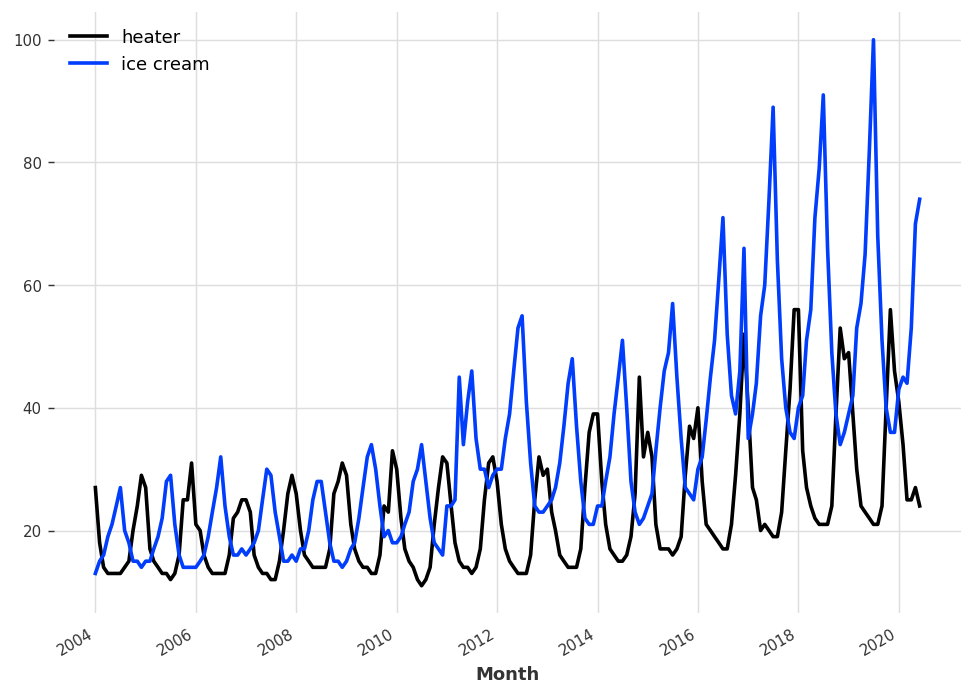

In [2]:
# convert monthly sales to average daily sales per month
converted_series = []
for col in ["ice cream", "heater"]:
    converted_series.append(
        series_ice_heater[col]
        / TimeSeries.from_series(series_ice_heater.time_index.days_in_month)
    )
converted_series = concatenate(converted_series, axis=1)
converted_series = converted_series[pd.Timestamp("20100101") :]

# define train/validation cutoff time
forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]

# use ice cream sales as target, create train and validation sets and transform data
series_ice = converted_series["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

# use heater sales as past covariates and transform data
covariates_heat = converted_series["heater"]
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)

# use `add_encoders` as we don't have future covariates
my_model_ice = TFTModel(
    input_chunk_length=36, # use the last 3 years as past input data
    output_chunk_length=forecast_horizon_ice,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}},
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

# fit the model with past covariates
my_model_ice.fit(train_ice_transformed, past_covariates=covariates_heat_transformed, verbose=True)

Predicting: 0it [00:00, ?it/s]

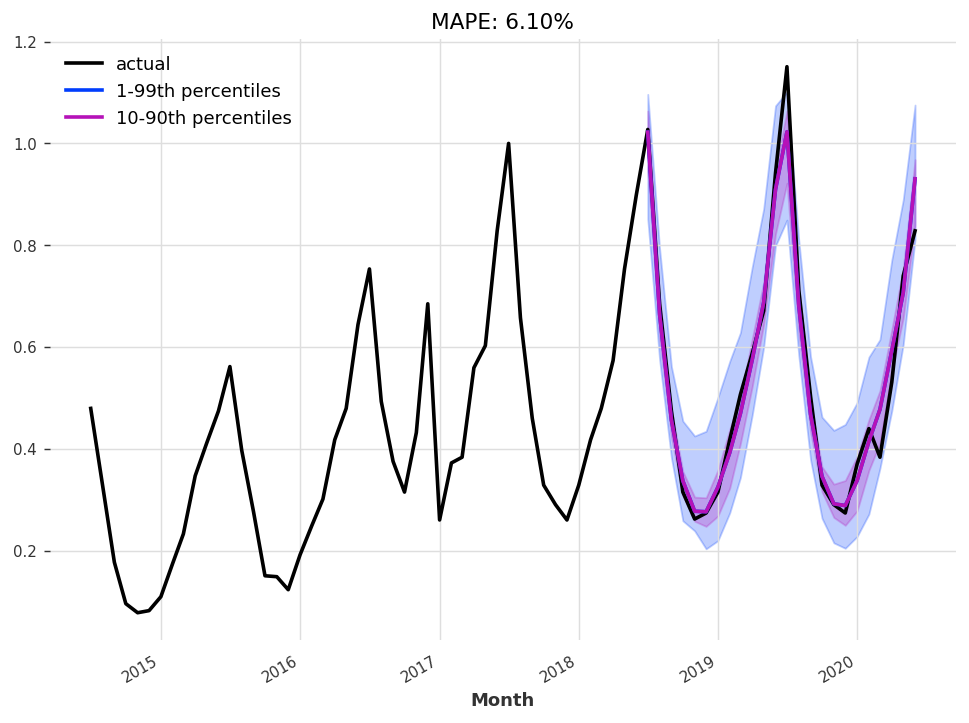

In [3]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()

n = 24
eval_model(
    model=my_model_ice,
    n=n,
    actual_series=series_ice_transformed[train_ice.end_time() - (2 * n - 1) * train_ice.freq :],
    val_series=val_ice_transformed,
)

  0%|          | 0/2 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  2.92it/s]

Predicting: 0it [00:00, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


MAPE: 4.17%


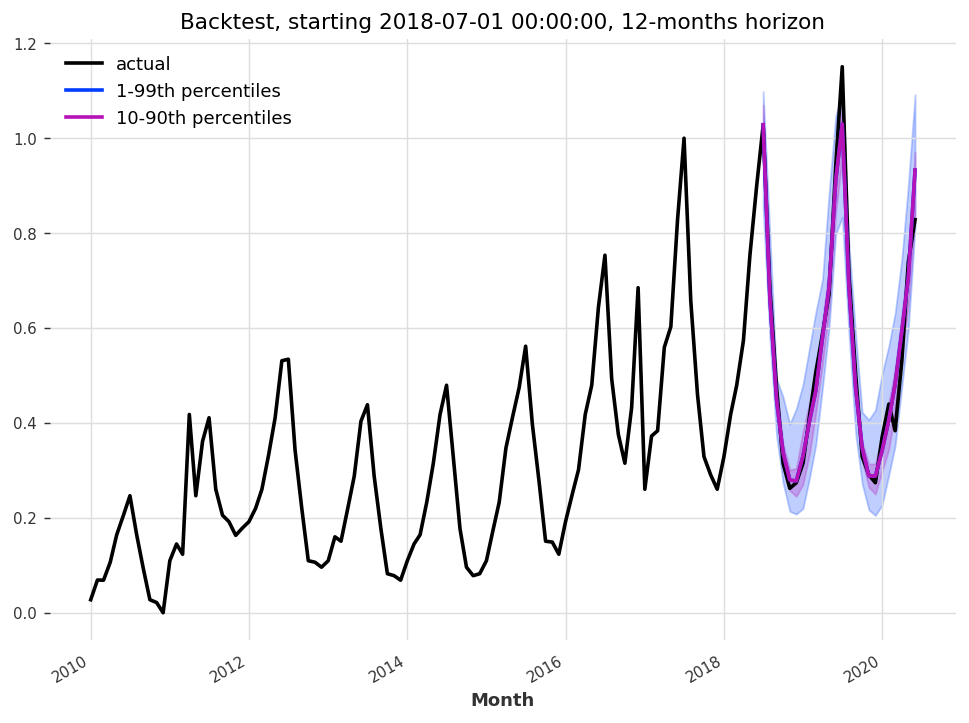

In [4]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print("MAPE: {:.2f}%".format(mape(transformer.inverse_transform(actual_series), transformer.inverse_transform(backtest_series))))

# Compute the backtest predictions with the two models
last_points_only = False
backtest_series_ice = my_model_ice.historical_forecasts(
    series_ice_transformed,
    num_samples=num_samples,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=1 if last_points_only else forecast_horizon_ice,
    retrain=False,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)


backtest_series_ice = (concatenate(backtest_series_ice) if isinstance(backtest_series_ice, list) else backtest_series_ice)
eval_backtest(
    backtest_series=backtest_series_ice,
    actual_series=series_ice_transformed[train_ice.start_time() - 2 * forecast_horizon_ice * train_ice.freq :],
    horizon=forecast_horizon_ice,
    start=training_cutoff_ice,
    transformer=transformer_ice,
)